## Background information
Horizontal drilling which provides additional exposure of the reservoir to the wellbore (lateral length) is one of the primary drivers that made economic production of oil and gas from the tight shale reservoirs in the US a success, in conjunction with stimulation using hydraulic fracturing.

## Objective
Objective of this study is to understand effect of lateral length of a horizontal well on shale gas production in some of the US shale plays using multiple linear regression analysis. While lateral length would be one of the primary predictors, other variables considered are vertical section length of the horizontal well, proppant volume and fluid volume pumped for stimulating the horizontal section of the well using hydraulic fracturing.

## Data Source
National Oil and Gas Gateway (http://www.noggateway.org/explore)
From participating states that contribute to this data source, Arkansas and Colorado were identified as states of interest for the project owing to the level of shale gas drilling and production activity in these states over the period 2008-2018 and data availability on Fluids and Proppants.

In [1]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as st

In [2]:
from platform import python_version

print('The Python version is {}.' .format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The Python version is 3.8.2.
The scikit-learn version is 0.23.2.


We'll work with the production.csv. It has numerical value columns:

### Response (Target) variable: 
#### Max_Gas: Maximum Gas Production (Million Standard Cubic Feet, MSCF)
### Predictor variables:
##### Lat_Len: Lateral length of the horizontal section (feet)
##### Vert_Len: Length of the vertical section (feet)
##### Fluid: Total amount of fracturing fluid (typically water) pumped to create the hydraulic fractures (Barrels)
##### Proppant: Total amount of proppant (typically sand) pumped along with the fracturing fluid as a slurry to keep the hydraulically created fractures open (Pounds)

Since shale gas wells have their peak production in the first 2-3 years after the well is drilled, stimulated and put on production, maximum annual gas production is selected as the best response variable to predict using the selected predictor variables.


In [3]:
df = pd.read_csv('production.csv', index_col=0)
df.head()

,Well.API,Field,Operator,Spud.Year,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant,ShalePlay
Index,,,,,,,,,,
1,5.045130e+12,Grand Valley,Caerus Piceance Llc,2008,99971,1507,6950,15904,492500,Mancos
2,5.045130e+12,Grand Valley,Berry Petroleum Company Llc,2008,124446,1707,8265,48520,458360,Mancos
3,5.045140e+12,Mamm Creek,Ursa Operating Company Llc,2012,132394,1644,6039,89263,1915300,Mancos
4,5.045150e+12,Mamm Creek,Ursa Operating Company Llc,2012,121659,1646,6067,88929,1849000,Mancos
5,5.045150e+12,Mamm Creek,Ursa Operating Company Llc,2012,120910,1645,6048,91243,2829500,Mancos


In [4]:
df.drop(['Well.API', 'Field', 'Operator', 'Spud.Year','ShalePlay'], axis=1, inplace=True)
df.head()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant
Index,,,,,
1,99971,1507,6950,15904,492500
2,124446,1707,8265,48520,458360
3,132394,1644,6039,89263,1915300
4,121659,1646,6067,88929,1849000
5,120910,1645,6048,91243,2829500


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max_Gas,5168.0,4.227032e+05,2.160341e+05,452.0,264074.00,395956.0,549319.00,2887155.0
Lat_Len,5168.0,4.147998e+03,1.414552e+03,1017.0,3432.00,4137.0,4899.00,10403.0
Vert_Len,5168.0,4.567358e+03,1.432178e+03,435.0,3649.50,4394.5,5488.00,12380.0
Fluid,5168.0,1.555068e+05,3.707851e+05,66.0,78074.25,107552.0,138080.50,13009114.0
Proppant,5168.0,3.537080e+06,1.874401e+06,2000.0,2655423.25,3545450.0,4338383.25,36760020.0


In [6]:
np.min(df['Max_Gas'].values)

452

In [7]:
fmin = df.min()
fmin

Max_Gas      452
Lat_Len     1017
Vert_Len     435
Fluid         66
Proppant    2000
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5168 entries, 1 to 5168
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Max_Gas   5168 non-null   int64
 1   Lat_Len   5168 non-null   int64
 2   Vert_Len  5168 non-null   int64
 3   Fluid     5168 non-null   int64
 4   Proppant  5168 non-null   int64
dtypes: int64(5)
memory usage: 242.2 KB


## Clean Data and Data Visualization

In [9]:
print(df.isnull().sum())  ### Inspect null value
print(df.columns)

Max_Gas     0
Lat_Len     0
Vert_Len    0
Fluid       0
Proppant    0
dtype: int64
Index(['Max_Gas', 'Lat_Len', 'Vert_Len', 'Fluid', 'Proppant'], dtype='object')


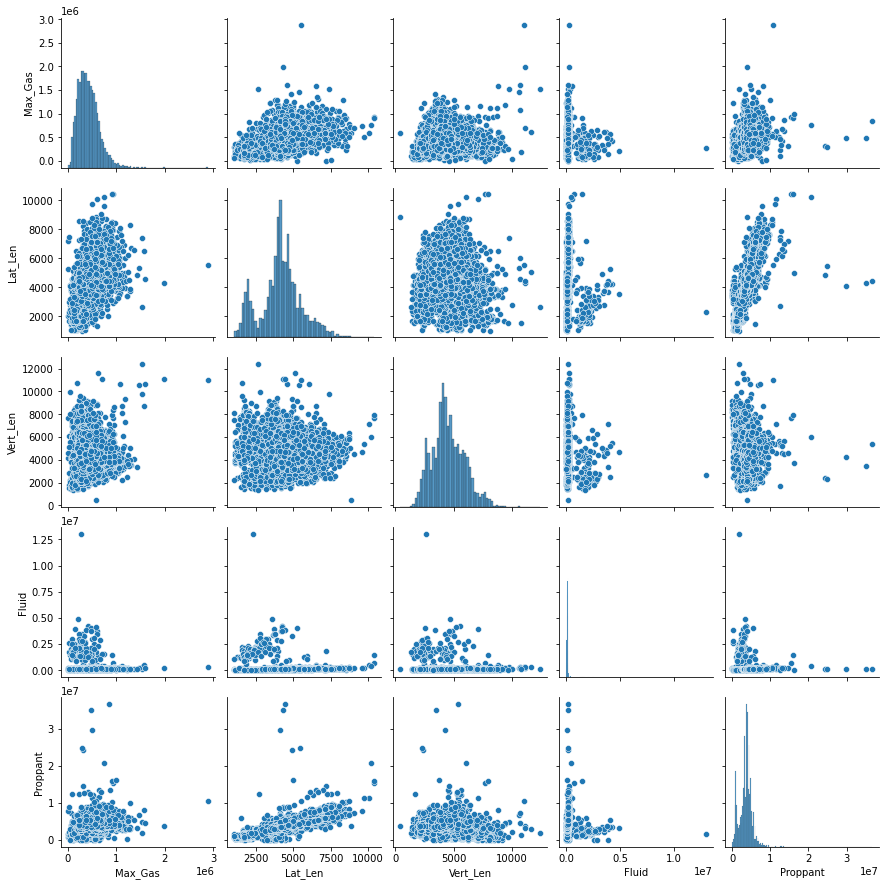

In [11]:
##Bivariate Distribution
sns.pairplot(df,vars=df.columns,markers='o')

### Feature Ranking

In [23]:
ncol = len(df.columns)
covariance = df.iloc[:,:].cov().iloc[:ncol,0]
print(covariance)

Max_Gas     4.667074e+10
Lat_Len     1.574670e+08
Vert_Len   -1.704423e+07
Fluid      -1.417912e+09
Proppant    1.727439e+11
Name: Max_Gas, dtype: float64


The covariance is useful, but the magnitude is quite variable and these magnitudes are a function of each feature's variance.

Pairwise correlation coefficient provides a measure fo the strength of the linear relationship and normalizes the covarian by the product of the standard deviation of each feature.

In [24]:
###Pairwise correlation coefficient
correlation = df.corr().iloc[0,:ncol]
print(correlation)

Max_Gas     1.000000
Lat_Len     0.515286
Vert_Len   -0.055088
Fluid      -0.017701
Proppant    0.426597
Name: Max_Gas, dtype: float64


Lateral Length (r=0.52) and Proppant (r=0.43) have the highest impact on prediction

In [25]:
## The rank correlation coefficient 
## Apply the rank transform to the data prior to calculating the correlation coefficent
from scipy import stats 
rank_correlation, rank_correlation_pval = stats.spearmanr(df)
rank_correlation = rank_correlation[0,:ncol]
rank_correlation_pval = rank_correlation_pval[0,:ncol]
print(rank_correlation)
print(rank_correlation_pval)

[ 1.          0.54500494 -0.10129444  0.44512328  0.50818343]
[0.00000000e+000 0.00000000e+000 2.90012656e-013 4.90283063e-250
 0.00000000e+000]


Increased the correlation between Vert_Len and Max_Gas, and Fluid and Max_Gas by relaxing the linear assumption.

Correlation between Vert_Len and Max_Gas is still low due to the monotonic assumption within the rank correlation.

High correlation between Fluid and Max_Gas suggests the possible outliers and issues in linearity.

Only the Lat_Len v.s. Max_Gas rank correlation coefficient is not significantly different.

In [26]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com
from scipy import linalg
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr
def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [27]:
#Partial Correlation
partial_correlation = partial_corr(df)
partial_correlation = partial_correlation[0,:ncol]
print(partial_correlation)

[1.         0.41783349 0.1402373  0.01737869 0.05230332]


Proppant is strongly correlated with other predictors so it is penalized severely

Vert_Len absolute correlation is increased reflecting its unique contributions

When controled for all other variables, Fluid has a negative relationship with production.

With the partial correlation coefficients the influence of all other predictor features on both the specific predictor and the response features are controled. The semipartial correlation filters out the influence of all other predictor features on the raw response variable.

Semipartial correlation coefficient is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$. Note: we do not control for influence of $Z$ features on the response feature, $Y$.

The semipartial correlation coefficient, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other predictor features on the predictor feature, $X$, to get the unique contribution of $X$ with respect to $Y$. We use a modified version of the partial correlation function that we declared previously. The original code is on GitHub at https://git.io/fhyHB.

In [28]:
### Semipartial correlation 
### Filters out the influence of all other predictor features on the raw response variable
semipartial_correlation = semipartial_corr(df)
semipartial_correlation = semipartial_correlation[0,:ncol]
print(semipartial_correlation)

[ 1.          0.14616618 -0.34928999 -0.06624946  0.08611645]


Lat_Len, and Vert_Len are the most important by this feature ranking method All other predictor features have quite low correlations

In [29]:
features = df.columns
ncol = len(df.columns)
nsamp = len(df)
features[1:ncol]

Index(['Lat_Len', 'Vert_Len', 'Fluid', 'Proppant'], dtype='object')

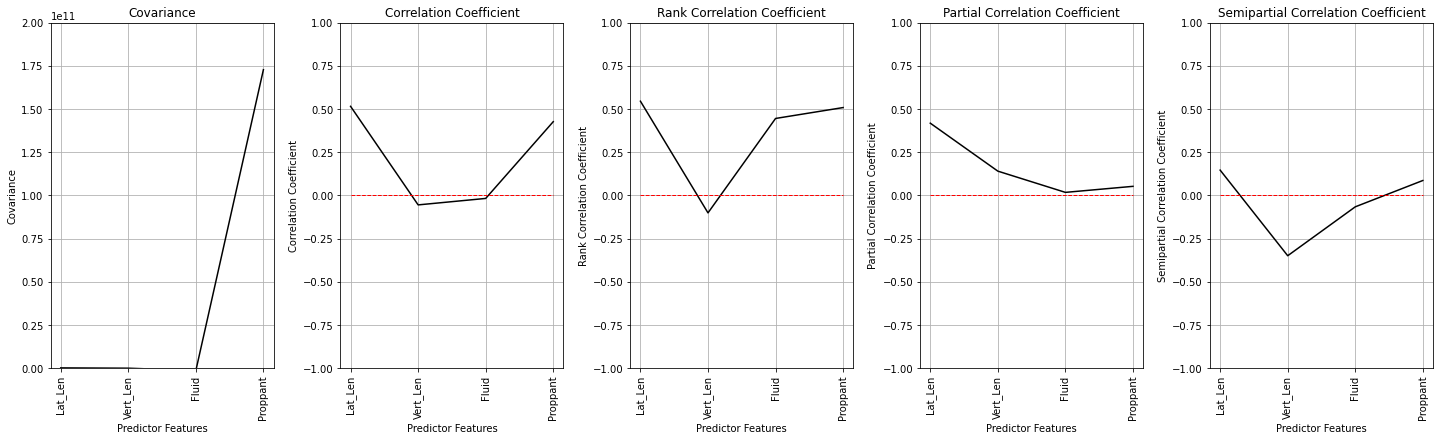

In [30]:
plt.subplot(151)
plt.plot(features[1:ncol],covariance[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Covariance');
t = plt.title('Covariance')
plt.ylim(-1.0e7,2.0e11)
plt.grid(True)

plt.subplot(152)
plt.plot(features[1:ncol],correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features[1:ncol],rank_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[1:ncol],partial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[1:ncol],semipartial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Increasing between correlation and rank correlation in Fluid suggests major issue of outliers or linearity.

Low absolute correlation for Fluid and Proppand suggest that they are correlated with other features.

#### Joint, Conditional and Marginals
Kernel density estimation is used to estimate the joint probabilities density function (pdf) for the paired data. This could be used to estimate any required joint, marginal and conditional probability.

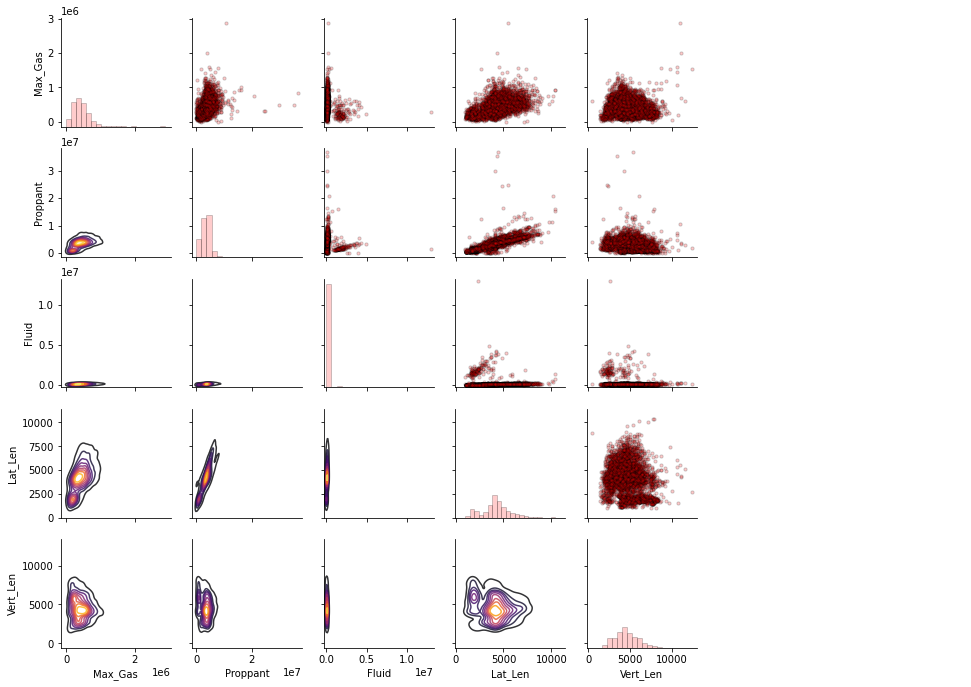

In [31]:
pairgrid = sns.PairGrid(df,vars=['Max_Gas','Proppant','Fluid', 'Lat_Len', 'Vert_Len'])
pairgrid = pairgrid.map_upper(plt.scatter, color = 'red', edgecolor = 'black', alpha = 0.2, s=10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'red', alpha = 0.2, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, thresh=0.05, alpha = 0.8, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.7, wspace=0.2, hspace=0.2)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lat_Len vs. Max_Gas')

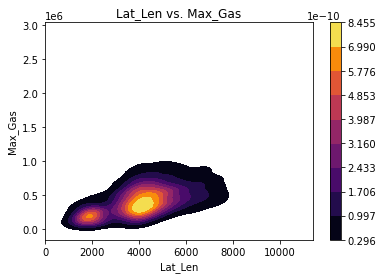

In [32]:
ax = sns.kdeplot(df['Lat_Len'].values,df['Max_Gas'].values, shade=True, n_levels = 10, cbar= True, cmap = plt.cm.inferno, thresh=0.05)
ax.set_xlabel('Lat_Len'); ax.set_ylabel('Max_Gas'); ax.set_title('Lat_Len vs. Max_Gas')

## Process-1

#### Remove outlier using IQR (Inter Quartile Range)

In [33]:
##log_Max_Gas IQR
Q1_lg = np.quantile(df['Max_Gas'],0.25)
Q3_lg = np.quantile(df['Max_Gas'],0.75)
IQR_lg = Q3_lg - Q1_lg
Low_lg = Q1_lg - 1.5*IQR_lg
High_lg = Q3_lg + 1.5*IQR_lg
##Lat_Len IQR
Q1_ll = np.quantile(df['Lat_Len'],0.25)
Q3_ll = np.quantile(df['Lat_Len'],0.75)
IQR_ll = Q3_ll - Q1_ll
Low_ll = Q1_ll - 1.5*IQR_ll
High_ll = Q3_ll + 1.5*IQR_ll
##Vert_Len IQR
Q1_vl = np.quantile(df['Vert_Len'],0.25)
Q3_vl = np.quantile(df['Vert_Len'],0.75)
IQR_vl = Q3_vl - Q1_vl
Low_vl = Q1_vl - 1.5*IQR_vl
High_vl = Q3_vl + 1.5*IQR_vl
##Fluid IQR
Q1_fl = np.quantile(df['Fluid'],0.25)
Q3_fl = np.quantile(df['Fluid'],0.75)
IQR_fl = Q3_fl - Q1_fl
Low_fl = Q1_fl - 1.5*IQR_fl
High_fl = Q3_fl + 1.5*IQR_fl
##Proppant IQR
Q1_prop = np.quantile(df['Proppant'],0.25)
Q3_prop = np.quantile(df['Proppant'],0.75)
IQR_prop = Q3_prop - Q1_prop
Low_prop = Q1_prop - 1.5*IQR_prop
High_prop = Q3_prop + 1.5*IQR_prop

df_IQR = df.loc[(df['Max_Gas'] > Low_lg) & (df['Max_Gas'] < High_lg) & 
                  #(df['Lat_Len'] > Low_ll) & (df['Lat_Len'] < High_ll) & ## Exclude outliers from Lat_Len doesn't improve overall correlation
                  #(df['Vert_Len'] > Low_vl) & (df['Vert_Len'] < High_vl) & ## Exclude outliers from Vert_Len doesn't improve overall correlation
                  (df['Fluid'] > Low_fl) & (df['Fluid'] < High_fl) &
                  (df['Proppant'] > Low_prop) & (df['Proppant'] < High_prop)]
df_IQR.describe()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant
count,4795.000000,4795.000000,4795.000000,4795.000000,4.795000e+03
mean,410509.604171,4103.208968,4580.182482,101567.541189,3.406907e+06
std,191612.983717,1323.698445,1383.692427,44540.789094,1.408270e+06
min,593.000000,1017.000000,435.000000,66.000000,1.859000e+05
25%,263370.500000,3453.000000,3693.000000,75272.000000,2.710404e+06
50%,391403.000000,4136.000000,4407.000000,103861.000000,3.534200e+06
75%,538187.500000,4840.000000,5505.500000,132895.500000,4.310384e+06
max,976137.000000,8881.000000,10738.000000,227929.000000,6.856487e+06


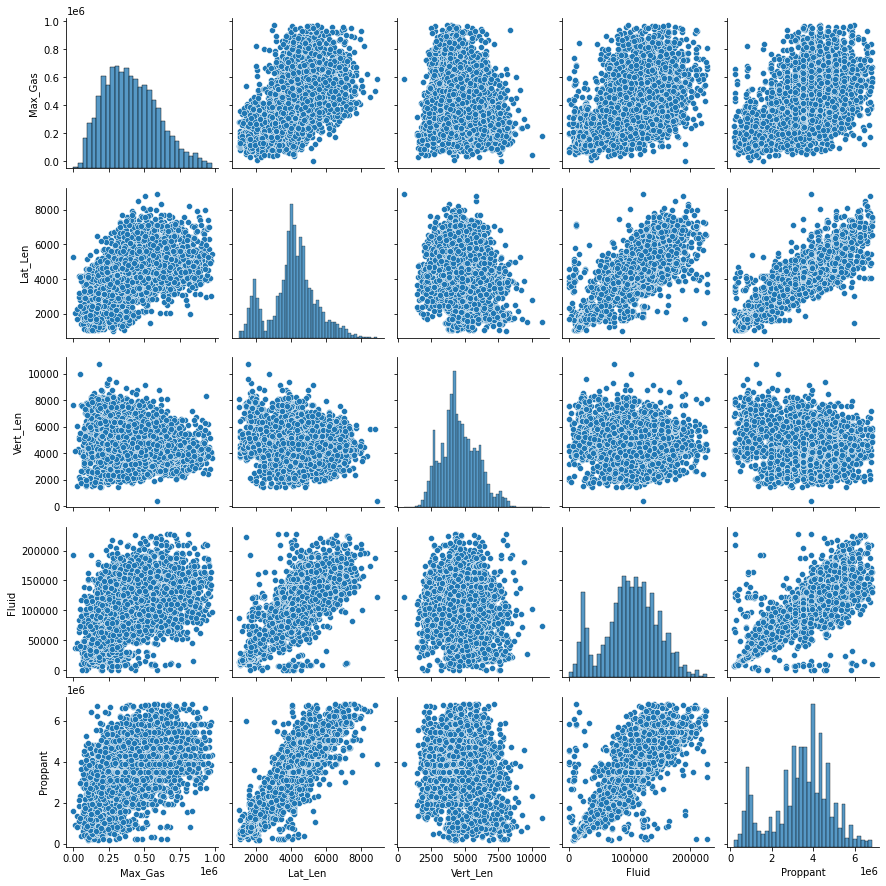

In [34]:
##Bivariate Distribution
sns.pairplot(df_IQR,vars=df.columns,markers='o')

### Feature Ranking

In [35]:
ncol = len(df_IQR.columns)
features = df_IQR.columns

##Covariance
covariance = df_IQR.cov().iloc[:ncol,0]
print('covariance')
print(covariance)
print('\n')

###Pairwise correlation coefficient
correlation = df_IQR.corr().iloc[0,:ncol]
print('correlation')
print(correlation)
print('\n')

###Rank correlation coefficient
rank_correlation, rank_correlation_pval = stats.spearmanr(df_IQR)
rank_correlation = rank_correlation[0,:ncol]
rank_correlation_pval = rank_correlation_pval[0,:ncol]
print('rank correlation')
print(rank_correlation)
print(rank_correlation_pval)
print('\n')

#Partial Correlation
partial_correlation = partial_corr(df_IQR)
partial_correlation = partial_correlation[0,:ncol]
print('partial correlation')
print(partial_correlation)
print('\n')

### Semipartial correlation 
semipartial_correlation = semipartial_corr(df_IQR)
semipartial_correlation = semipartial_correlation[0,:ncol]
print('semipartial correlation')
print(semipartial_correlation)

covariance
Max_Gas     3.671554e+10
Lat_Len     1.353782e+08
Vert_Len   -3.929807e+07
Fluid       4.204435e+09
Proppant    1.374155e+11
Name: Max_Gas, dtype: float64


correlation
Max_Gas     1.000000
Lat_Len     0.533746
Vert_Len   -0.148220
Fluid       0.492635
Proppant    0.509243
Name: Max_Gas, dtype: float64


rank correlation
[ 1.          0.53455911 -0.14755507  0.49738584  0.49868928]
[0.00000000e+000 0.00000000e+000 9.50219277e-025 3.63839079e-298
 5.79123182e-300]


partial correlation
[1.         0.2676711  0.11691061 0.12124792 0.02118041]


semipartial correlation
[ 1.          0.03135925 -0.40957481  0.11132453  0.04819096]


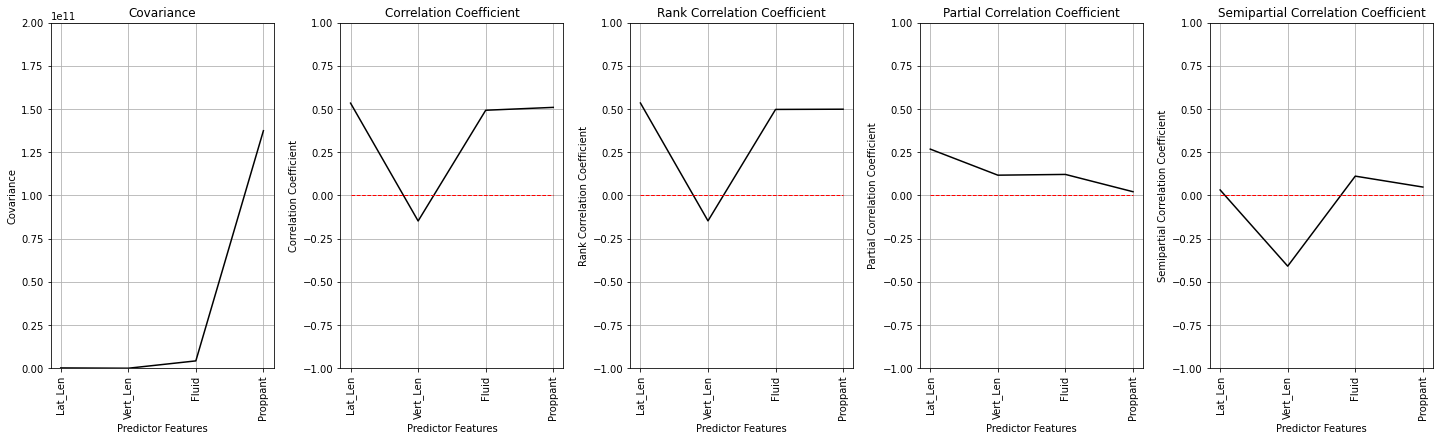

In [36]:
plt.subplot(151)
plt.plot(features[1:ncol],covariance[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Covariance');
t = plt.title('Covariance')
plt.ylim(-1.0e7,2.0e11)
plt.grid(True)

plt.subplot(152)
plt.plot(features[1:ncol],correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features[1:ncol],rank_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[1:ncol],partial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[1:ncol],semipartial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Similar pattern for Correlation Coefficient and Rank Correlation Coefficient suggests that there isn’t major issue for outliers or linearity in bivariate sense.

Vert_Len show high absolute correlation suggests its unique contribution.

Lat_Len, Vert_Len and Fluid are the most important variables with respect to linear relationships with the production.

#### Standardize
Standardize features by removing the mean and scaling to unit variance

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
scaler.fit(df_IQR)   
scaled_features = scaler.transform(df_IQR)
df_IQR_std = pd.DataFrame(scaled_features,columns=df_IQR.columns)
df_IQR_std.head()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant
0,-1.620824,-1.961534,1.712855,-1.923461,-2.069710
1,-1.493080,-1.810427,2.663310,-1.191112,-2.093955
2,-1.451596,-1.858025,1.054403,-0.276282,-1.059287
3,-1.507626,-1.856514,1.074641,-0.283782,-1.106371
4,-1.511535,-1.857270,1.060908,-0.231824,-0.410054


In [39]:
df_IQR_std.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max_Gas,4795.0,-4.741891e-17,1.000104,-2.139518,-0.767977,-0.099725,0.666402,2.952234
Lat_Len,4795.0,1.185473e-16,1.000104,-2.331748,-0.491257,0.024775,0.556674,3.609802
Vert_Len,4795.0,2.370946e-16,1.000104,-2.996052,-0.641237,-0.125173,0.668800,4.450743
Fluid,4795.0,8.298309e-17,1.000104,-2.279082,-0.590431,0.051497,0.703428,2.837279
Proppant,4795.0,-1.185473e-16,1.000104,-2.287447,-0.494632,0.090399,0.641617,2.449771


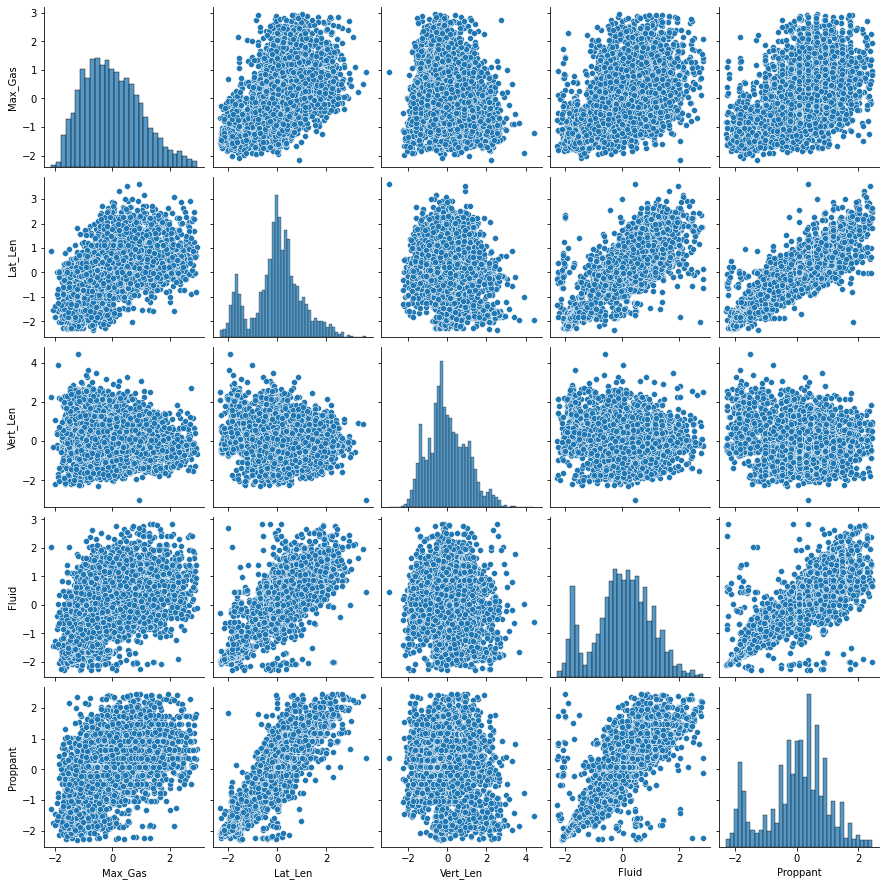

In [40]:
sns.pairplot(df_IQR_std,vars=df_IQR_std.columns,markers='o')

In [41]:
ncol = len(df_IQR_std.columns)
features = df_IQR_std.columns

##Covariance
covariance = df_IQR_std.cov().iloc[0,:ncol]
print('covariance')
print(covariance)
print('\n')

###Pairwise correlation coefficient
correlation = df_IQR_std.corr().iloc[0,:ncol]
print('correlation')
print(correlation)
print('\n')

###Rank correlation coefficient
rank_correlation, rank_correlation_pval = stats.spearmanr(df_IQR_std)
rank_correlation = rank_correlation[0,:ncol]
rank_correlation_pval = rank_correlation_pval[0,:ncol]
print('rank correlation')
print(rank_correlation)
print(rank_correlation_pval)
print('\n')

#Partial Correlation
partial_correlation = partial_corr(df_IQR_std)
partial_correlation = partial_correlation[0,:ncol]
print('partial correlation')
print(partial_correlation)
print('\n')

### Semipartial correlation 
semipartial_correlation = semipartial_corr(df_IQR_std)
semipartial_correlation = semipartial_correlation[0,:ncol]
print('semipartial correlation')
print(semipartial_correlation)

covariance
Max_Gas     1.000209
Lat_Len     0.533857
Vert_Len   -0.148251
Fluid       0.492737
Proppant    0.509349
Name: Max_Gas, dtype: float64


correlation
Max_Gas     1.000000
Lat_Len     0.533746
Vert_Len   -0.148220
Fluid       0.492635
Proppant    0.509243
Name: Max_Gas, dtype: float64


rank correlation
[ 1.          0.53455911 -0.14755507  0.49738584  0.49868928]
[0.00000000e+000 0.00000000e+000 9.50219277e-025 3.63839079e-298
 5.79123182e-300]


partial correlation
[ 1.          0.18552251 -0.02996737  0.12517347  0.03164056]


semipartial correlation
[ 1.          0.1575197  -0.02501361  0.10526265  0.02641158]


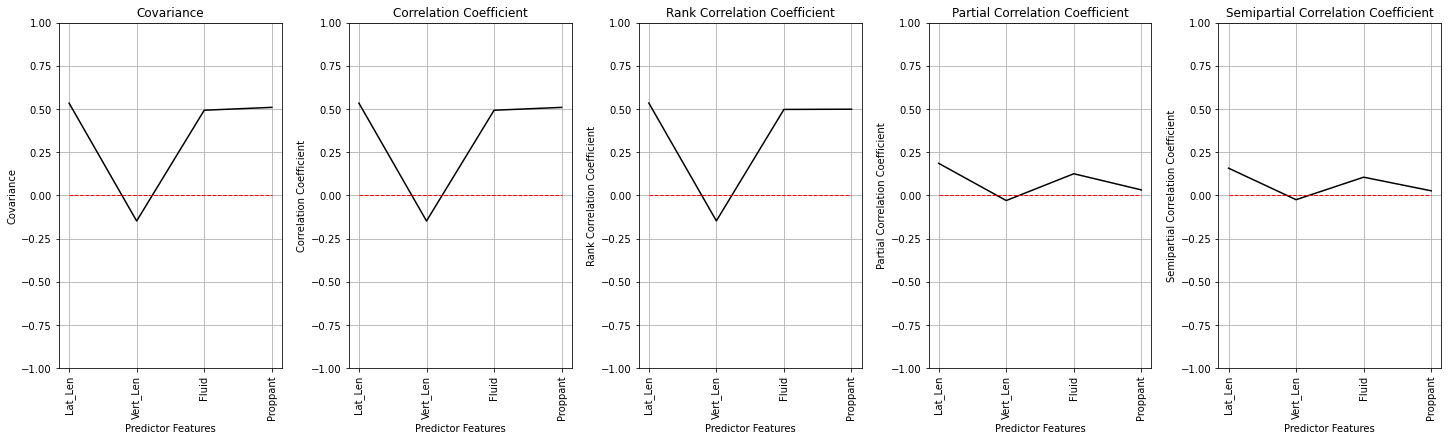

In [42]:
plt.subplot(151)
plt.plot(features[1:ncol],covariance[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Covariance');
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features[1:ncol],correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features[1:ncol],rank_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[1:ncol],partial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[1:ncol],semipartial_correlation[1:ncol],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Covariance is now equal to correlation coefficient
The semipartial correlations are sensitive to the feature standardization (affine correlation or normal score transform).

In [44]:
df_IQR_std['const'] = np.ones(len(df_IQR_std))                  # let's add one for the constant term
b = linalg.lstsq(df_IQR_std.iloc[:,1:ncol],df_IQR_std.iloc[:,[0]])[0]
df_IQR_std = df_IQR_std.drop('const',axis = 1)
print(b)

[[ 0.33227209]
 [-0.02585376]
 [ 0.18504234]
 [ 0.06199559]]


#### Mutual information is a generalized approach that quantifies the mutual dependence between two features.

-quantifies the amount of information gained from observing one feature about the other

-avoids any assumption about the form of the relationship (e.g. no assumption of linear relationship)

-compares the joint probabilities to the product of the marginal probabilities

In [45]:
from sklearn.feature_selection import mutual_info_regression

Feature ranking:
1. feature Lat_Len = 1.000000
2. feature Proppant = 0.833122
3. feature Fluid = 0.832413
4. feature Vert_Len = 0.271886


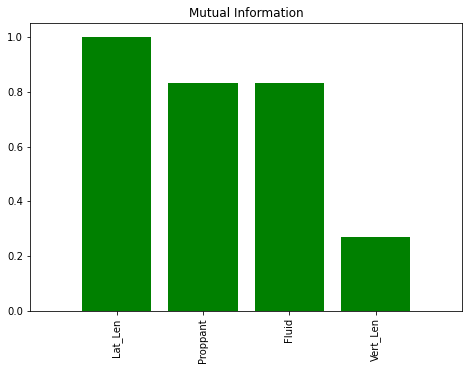

In [46]:
X = df_IQR_std.iloc[:,1:ncol]                   # separate DataFrames for predictor and response features
y = df_IQR_std.iloc[:,[0]]

mi = mutual_info_regression(X,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(X.shape[1]):
    print("%d. feature %s = %f" % (f + 1, X.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(X.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

#### A random forest regressor fit to the data can indicate the feature importance.

1. Instantiate a random forest.

2. Train the random forest and extract the importances (expectation over all the trees)

3. Extract the feature importances over all the trees in the forest and summarize with the standard deviation to access the robustness of feature importance measure

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

Mean Squared Error on Training =  0.41 , Variance Explained = 0.59
[0.28174926 0.16973986 0.25552816 0.29298272]
Feature ranking:
1. feature 3 (0.292983)
2. feature 0 (0.281749)
3. feature 2 (0.255528)
4. feature 1 (0.169740)


<ipython-input-67-d5e8fa494a25>:38: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  plt.scatter(y,y_hat,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")


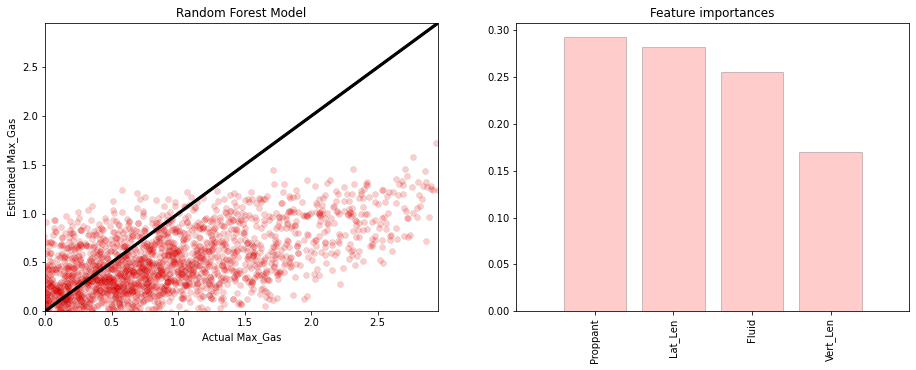

In [67]:
X = df_IQR_std.iloc[:,1:ncol]                   # separate DataFrames for predictor and response features
y = df_IQR_std.iloc[:,[0]]

fmin = df_IQR_std.min()
fmax = df_IQR_std.max()

seed = 73093                                                # set the random forest hyperparameters
###Underfit random forest
# max_leaf_nodes = 2
# num_tree = 10
# max_features = 0.2

## Overfit random forest
# max_leaf_nodes = 50
# num_tree = 1
# max_features = 0.6

# Good random forest
max_leaf_nodes = 200
num_tree = 300
max_features = 0.3

random_forest = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=seed, n_estimators=num_tree, max_features=max_features)
random_forest.fit(X = X, y = y.values.reshape(-1,))

y_hat = predict_train = random_forest.predict(X)

MSE = metrics.mean_squared_error(y,y_hat)
Var_Explained = metrics.explained_variance_score(y,y_hat)
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

importances = random_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([random_forest.feature_importances_ for tree in random_forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print(importances)

plt.subplot(121)
plt.scatter(y,y_hat,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Random Forest Model')
plt.xlabel('Actual ' + features[0]); plt.ylabel('Estimated ' + features[0] )
plt.xlim(0,fmax[0]); plt.ylim(0,fmax[0])
plt.arrow(0,0,fmax[0],fmax[0],width=0.02,color='black',head_length=0.0,head_width=0.0)

importance_rank = random_forest.feature_importances_/np.max(random_forest.feature_importances_)

print("Feature ranking:")                 # write out the feature importances
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(122)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.2)
plt.show()

In [68]:
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression

In [70]:
rfe = RFE(LinearRegression(), n_features_to_select=1, verbose=0)      # set up RFE linear regression model

#df_IQR_std['const'] = np.ones(len(df_IQR_std))   # let's add one's for the constant term
ncol = len(df_IQR_std.columns)

rfe = rfe.fit(df_IQR_std.iloc[:,1:ncol].values, np.ravel(df_IQR_std.iloc[:,[0]])) # recursive elimination

#df_IQR_std = df_IQR_std.drop('const',axis = 1)                 # remove the ones

rank = rfe.ranking_
rfeatures = df_IQR_std.iloc[:,1:ncol].columns
rank, rfeatures = zip(*sorted(zip(rank,rfeatures)))
print('The linear regression RFE features in rank order are ' + str(rfeatures) + '.')

The linear regression RFE features in rank order are ('Lat_Len', 'Fluid', 'Proppant', 'Vert_Len').


In [71]:
rfe_forest = RFE(random_forest,n_features_to_select = 1, verbose=0)             # instantiate with the previous model
#df_IQR_std['const'] = np.ones(len(df_IQR_std))            # let's add one's for the constant term

rfe_forest.fit(df_IQR_std.iloc[:,1:ncol].values,np.ravel(df_IQR_std.iloc[:,[0]])) # recursive elimination

rrank = rfe_forest.ranking_
rfeatures = df_IQR_std.iloc[:,1:ncol].columns
rrank, rfeatures = zip(*sorted(zip(rrank,rfeatures)))
print('The random forest regression RFE features in rank order are ' + str(rfeatures) + '.')

rfe_rank = ((ncol - 1) - rfe_forest.ranking_)/(ncol-1)
print('Feature RFE rank scores' + str(rfe_rank))

# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_forest.support_[i], rfe_forest.ranking_[i]))

The random forest regression RFE features in rank order are ('Lat_Len', 'Proppant', 'Fluid', 'Vert_Len').
Feature RFE rank scores[0.75 0.   0.25 0.5 ]
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected False, Rank: 3.000
Column: 3, Selected False, Rank: 2.000


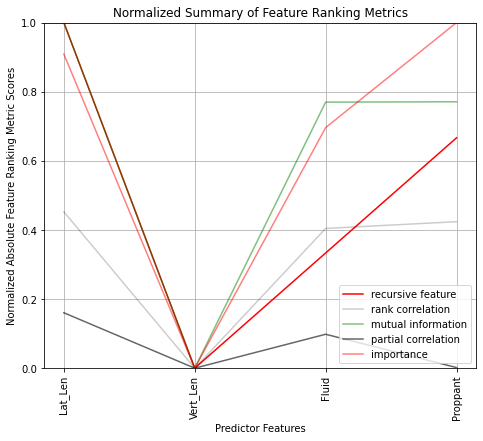

In [72]:
### Unified Wide Array Feature Ranking Display
### Normalize all scores to have a minimum of 0.0 and maximum of 1.0
### Grouping of metrics, correlation and feature importance
### Demote metrics that do not account for feature interactions by adding transparency

Nrfe = (rfe_rank - np.min(rfe_rank))/(np.max(rfe_rank) - np.min(rfe_rank))
Ncorrelation = (np.abs(correlation) - np.min(np.abs(correlation)))/(np.max(np.abs(correlation)) - np.min(np.abs(correlation)))
Nimportance = (importance_rank - np.min(importance_rank))/(np.max(np.abs(importance_rank)) - np.min(np.abs(importance_rank)))
Nmi = (mi - np.min(mi))/(np.max(mi) - np.min(mi))
Npartial_correlation = (np.abs(partial_correlation) - np.min(np.abs(partial_correlation)))/(np.max(np.abs(partial_correlation)) - np.min(np.abs(partial_correlation)))

plt.subplot(111)
plt.plot(features[1:ncol],Nrfe,color='red',label='recursive feature')
plt.plot(features[1:ncol],Ncorrelation[1:ncol],color='black',alpha=0.2,label='rank correlation')
plt.plot(features[1:ncol],Nmi,color='green',alpha = 0.5,label='mutual information')
plt.plot(features[1:ncol],Npartial_correlation[1:ncol],color='black',alpha = 0.6,label='partial correlation')
plt.plot(features[1:ncol],Nimportance,color='red',alpha=0.5,label='importance')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Absolute Feature Ranking Metric Scores')
t = plt.title('Normalized Summary of Feature Ranking Metrics')
plt.ylim(0,1)
plt.grid(True)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

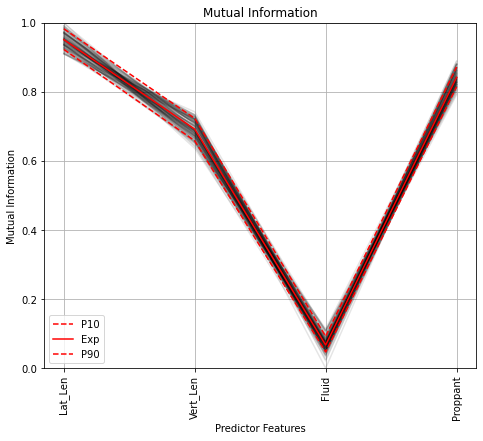

In [73]:
### Account for Uncertainty using mutual information and based on bootstrap

L = 100

mi_mat = np.zeros([L,ncol-1])

plt.subplot(111)

for l in range(0,L):
    bootstrap_df = pd.DataFrame(df.iloc[np.random.randint(len(df), size=len(df)),:])
    X = bootstrap_df.iloc[:,1:ncol]                   # separate DataFrames for predictor and response features
    y = bootstrap_df.iloc[:,[0]]

    mi = mutual_info_regression(X,np.ravel(y)) # calculate mutual information
    mi = mi - np.average(mi) + 0.5                  # recenter the mutual information measure
    #mi /= np.max(mi)                          # calculate relative mutual information
    mi_mat[l,:] = mi

mi_mat = (mi_mat - np.min(mi_mat.flatten()))/(np.max(mi_mat.flatten()) - np.min(mi_mat.flatten())) 

for l in range(0,L):    
    plt.plot(features[1:ncol],mi_mat[l,:],color='black',alpha = 0.1)
    
plt.plot(features[1:ncol],np.percentile(mi_mat,10.0,axis = 0),'--',color='red',alpha = 1.0,label='P10')
plt.plot(features[1:ncol],np.average(mi_mat,axis = 0),color='red',alpha = 1.0,label='Exp')
plt.plot(features[1:ncol],np.percentile(mi_mat,90.0,axis = 0),'--',color='red',alpha = 1.0,label='P90')

plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Mutual Information')
t = plt.title('Mutual Information')
plt.ylim(0.0,1)
plt.grid(True)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Split training and testing data

In [74]:
from sklearn.model_selection import train_test_split

In [100]:
#### Select Columns
x = df_IQR_std.drop('Max_Gas',axis=1) ## Max_Gas is the target values
y = df_IQR_std['Max_Gas']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print(len(y_train))
print(len(y_test))
print(x_train.describe())

3836
959
           Lat_Len     Vert_Len        Fluid     Proppant  log_Max_Gas
count  3836.000000  3836.000000  3836.000000  3836.000000  1800.000000
mean      0.011353    -0.001099     0.011499     0.013578    -0.557187
std       0.993438     0.993972     0.989676     0.990217     1.135201
min      -2.312104    -2.996052    -2.278431    -2.281694    -7.534283
25%      -0.472369    -0.632564    -0.578997    -0.480716    -1.049996
50%       0.025530    -0.122282     0.066686     0.100506    -0.312893
75%       0.556674     0.655068     0.700857     0.642955     0.225589
max       3.609802     4.450743     2.837279     2.449717     1.082562


### Model Training and Testing
#### Linear Regression

In [76]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Coefficients: 
 Index(['Max_Gas', 'Lat_Len', 'Vert_Len', 'Fluid', 'Proppant'], dtype='object') 
 [ 0.32443686 -0.02994907  0.19207782  0.06176979]
Intercept:  0.0020815027671376865
RMSE: 0.82
R2: 0.33
Correlation: 0.57


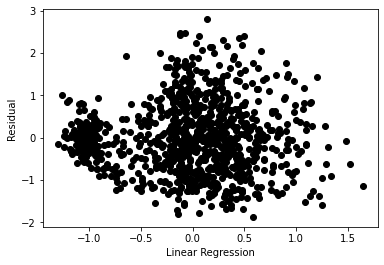

In [86]:
reg = linear_model.LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

# The coefficients
print('Coefficients: \n', df_IQR_std.columns, '\n', reg.coef_)
# The intercept
print('Intercept: ', reg.intercept_)
# The mean squared error
print('RMSE: %.2f'
      % mean_squared_error(y_test, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print('R2: %.2f'
      % r2_score(y_test, y_pred))
# The Correlation between predict and test
print('Correlation: %.2f' 
      % np.corrcoef(y_test, y_pred)[0,1])

# Plot outputs
plt.scatter(y_pred, (y_test-y_pred),  color='black')
#plt.plot(x_test['Lat_Len'], y_pred, color='blue', linewidth=3)

plt.xlabel('Linear Regression')
plt.ylabel('Residual')
plt.show()

#### Remarks
The scatter plot of residual and linear regression prediciton show a mega-phone pattern. This indicates non-constant variance and questions model validity.
Variable transformation can be applied to address this issue.

## Process-2
#### Variable Trasformation

In [112]:
df_IQR['log_Max_Gas'] = np.log(df_IQR['Max_Gas'])
df_IQR.describe()

<ipython-input-112-9d3ddf12afb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IQR['log_Max_Gas'] = np.log(df_IQR['Max_Gas'])


,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant,log_Max_Gas
count,4795.000000,4795.000000,4795.000000,4795.000000,4.795000e+03,4795.000000
mean,410509.604171,4103.208968,4580.182482,101567.541189,3.406907e+06,12.796441
std,191612.983717,1323.698445,1383.692427,44540.789094,1.408270e+06,0.548807
min,593.000000,1017.000000,435.000000,66.000000,1.859000e+05,6.385194
25%,263370.500000,3453.000000,3693.000000,75272.000000,2.710404e+06,12.481317
50%,391403.000000,4136.000000,4407.000000,103861.000000,3.534200e+06,12.877493
75%,538187.500000,4840.000000,5505.500000,132895.500000,4.310384e+06,13.195962
max,976137.000000,8881.000000,10738.000000,227929.000000,6.856487e+06,13.791358


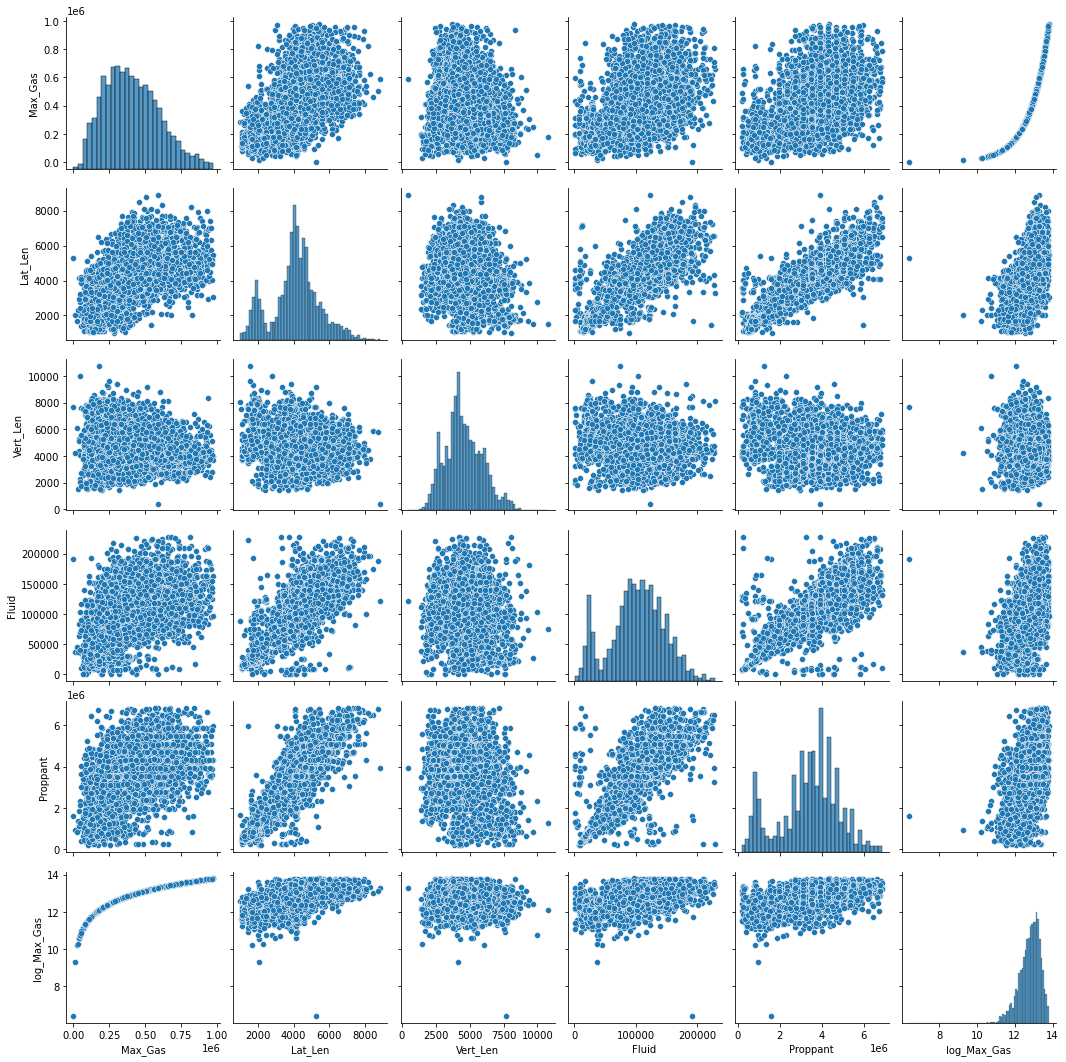

In [105]:
sns.pairplot(df_IQR,vars=df_IQR_std.columns,markers='o')

#### Standardize
Standardize features by removing the mean and scaling to unit variance

In [108]:
scaler = StandardScaler()
scaler.fit(df_IQR)   
scaled_features = scaler.transform(df_IQR)
df_IQR_std = pd.DataFrame(scaled_features,columns=df_IQR.columns)
df_IQR_std.describe()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant,log_Max_Gas
count,4.795000e+03,4.795000e+03,4.795000e+03,4.795000e+03,4.795000e+03,4.795000e+03
mean,-4.741891e-17,1.185473e-16,2.370946e-16,8.298309e-17,-1.185473e-16,-2.465783e-15
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00
min,-2.139518e+00,-2.331748e+00,-2.996052e+00,-2.279082e+00,-2.287447e+00,-1.168336e+01
25%,-7.679774e-01,-4.912575e-01,-6.412372e-01,-5.904315e-01,-4.946325e-01,-5.742569e-01
50%,-9.972496e-02,2.477487e-02,-1.251727e-01,5.149657e-02,9.039899e-02,1.477036e-01
75%,6.664017e-01,5.566735e-01,6.688004e-01,7.034277e-01,6.416174e-01,7.280576e-01
max,2.952234e+00,3.609802e+00,4.450743e+00,2.837279e+00,2.449771e+00,1.813061e+00


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lat_Len v.s. log_Max_Gas')

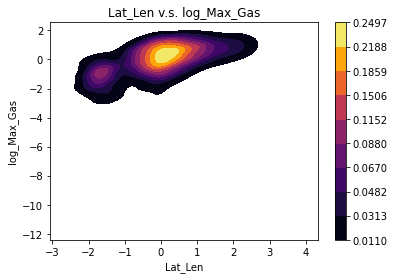

In [109]:
ax = sns.kdeplot(df_IQR_std['Lat_Len'].values,df_IQR_std['log_Max_Gas'].values, shade=True, n_levels = 10, cbar= True, cmap = plt.cm.inferno, thresh=0.05)
ax.set_xlabel('Lat_Len'); ax.set_ylabel('log_Max_Gas'); ax.set_title('Lat_Len v.s. log_Max_Gas')

#### Split training and testing data

In [110]:
from sklearn.model_selection import train_test_split

#### Select Columns
x = df_IQR_std.drop(['Max_Gas', 'log_Max_Gas'], axis=1) ## log_Max_Gas is the target values
y = df_IQR_std['log_Max_Gas']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print(x_train.shape)
print(len(y_train))
print(x_test.shape)

(3836, 4)
3836
(959, 4)


## Training and Testing
##### Linear Regression

Parameters:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Index(['Lat_Len', 'Vert_Len', 'Fluid', 'Proppant'], dtype='object')
Coefficients:  [ 0.29585945 -0.03780187  0.16410759  0.13977018]
Intercept:  0.0025357412631366056
RMSE: 0.82
R2: 0.35
Correlation: 0.59


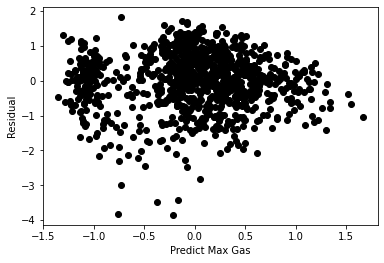

In [111]:
reg = linear_model.LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

# The parameters
print('Parameters: ', reg.get_params())
# The coefficients
print(x_train.columns)
print('Coefficients: ', reg.coef_)
# The intercept
print('Intercept: ', reg.intercept_)
# The mean squared error
print('RMSE: %.2f'
      % mean_squared_error(y_test, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print('R2: %.2f'
      % r2_score(y_test, y_pred))
# The Correlation between predict and test
print('Correlation: %.2f' 
      % np.corrcoef(y_test, y_pred)[0,1])

# Plot outputs
plt.scatter(y_pred, (y_test-y_pred),  color='black')
#plt.plot(x_test['Lat_Len'], y_pred, color='blue', linewidth=3)
plt.xlabel('Predict Max Gas')
plt.ylabel('Residual')
#plt.plot([5,20], [5,20], 'red')
plt.show()

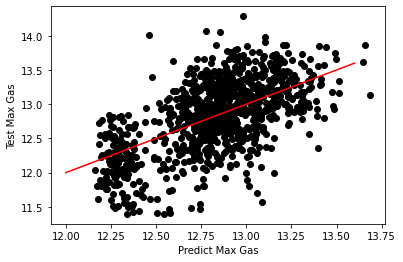

In [126]:
plt.scatter(y_pred, y_test,  color='black')
plt.xlabel('Predict Max Gas')
plt.ylabel('Test Max Gas')
plt.plot([12,13.6], [12,13.6], 'red', label='1:1')
plt.show()

## Preprocess-3

#### Remove outlier using Z-score

In [113]:
from scipy import stats
df['z_logMaxgas']=stats.zscore(df['log_Max_Gas'])
df['z_prop']=stats.zscore(df['Proppant'])
df['z_Lat_Len']=stats.zscore(df['Lat_Len'])
df['z_Fluid']=stats.zscore(df['Fluid'])  ### Exclude outliers from Vert_Len and Lat-Len doesn't improve overall correlation
df_z = df.loc[(df['z_logMaxgas'].abs()<=3) & (df['z_prop'].abs()<=3) & (df['z_Fluid'].abs()<=3)]
df_z.describe()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant,log_Max_Gas,z_logMaxgas,z_prop,z_Lat_Len,z_Fluid
count,4.997000e+03,4997.000000,4997.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4997.000000,4997.000000,4997.000000
mean,4.258706e+05,4166.519912,4594.454072,1.078206e+05,3.497859e+06,12.829125,0.031741,-0.020926,0.013095,-0.128621
std,2.114297e+05,1377.424247,1412.174475,7.327950e+04,1.528340e+06,0.541677,0.933123,0.815454,0.973847,0.197652
min,6.500600e+04,1017.000000,435.000000,6.600000e+01,2.000000e+03,11.082235,-2.977545,-1.886161,-2.213634,-0.419261
25%,2.696570e+05,3481.000000,3700.000000,7.721900e+04,2.728471e+06,12.504906,-0.526775,-0.431437,-0.471572,-0.211161
50%,3.992800e+05,4152.000000,4410.000000,1.062390e+05,3.574104e+06,12.897418,0.149388,0.019755,0.002829,-0.132887
75%,5.511760e+05,4899.000000,5518.000000,1.356240e+05,4.339040e+06,13.219809,0.704756,0.427890,0.530963,-0.053629
max,1.992645e+06,9605.000000,12380.000000,1.260660e+06,9.120277e+06,14.504973,2.918649,2.978945,3.858132,2.980865


In [114]:
df_z.corr()

,Max_Gas,Lat_Len,Vert_Len,Fluid,Proppant,log_Max_Gas,z_logMaxgas,z_prop,z_Lat_Len,z_Fluid
Max_Gas,1.000000,0.513633,-0.092699,0.290448,0.479333,0.940299,0.940299,0.479333,0.513633,0.290448
Lat_Len,0.513633,1.000000,-0.205635,0.430401,0.867743,0.564072,0.564072,0.867743,1.000000,0.430401
Vert_Len,-0.092699,-0.205635,1.000000,-0.085959,-0.191565,-0.122616,-0.122616,-0.191565,-0.205635,-0.085959
Fluid,0.290448,0.430401,-0.085959,1.000000,0.459737,0.306336,0.306336,0.459737,0.430401,1.000000
Proppant,0.479333,0.867743,-0.191565,0.459737,1.000000,0.531386,0.531386,1.000000,0.867743,0.459737
log_Max_Gas,0.940299,0.564072,-0.122616,0.306336,0.531386,1.000000,1.000000,0.531386,0.564072,0.306336
z_logMaxgas,0.940299,0.564072,-0.122616,0.306336,0.531386,1.000000,1.000000,0.531386,0.564072,0.306336
z_prop,0.479333,0.867743,-0.191565,0.459737,1.000000,0.531386,0.531386,1.000000,0.867743,0.459737
z_Lat_Len,0.513633,1.000000,-0.205635,0.430401,0.867743,0.564072,0.564072,0.867743,1.000000,0.430401
z_Fluid,0.290448,0.430401,-0.085959,1.000000,0.459737,0.306336,0.306336,0.459737,0.430401,1.000000


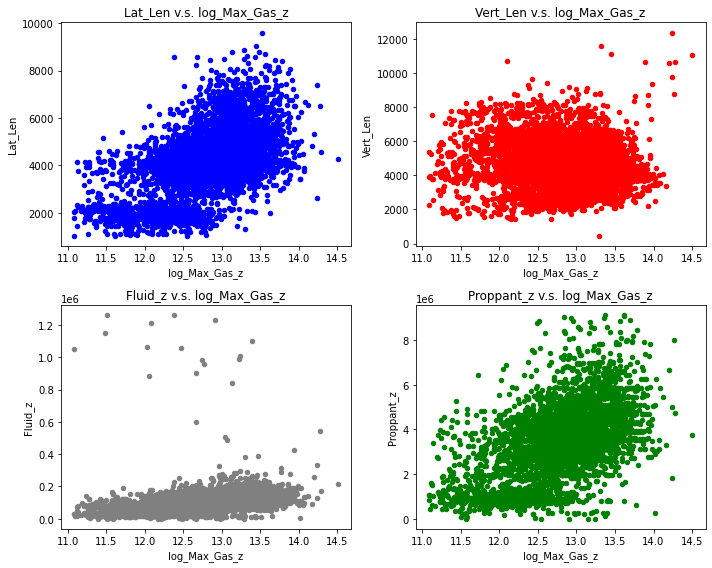

In [115]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (2 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (2 row, 2 columns, second plot)
ax2 = fig.add_subplot(2, 2, 3) # add subplot 3 (2 row, 2 columns, third plot)
ax3 = fig.add_subplot(2, 2, 4) # add subplot 4 (2 row, 2 columns, forth plot)

# Subplot 1: Lat_Len v.s. Max_Gas
df_z.plot(kind='scatter', x='log_Max_Gas', y='Lat_Len', figsize=(10, 8), color='blue', ax=ax0) # add to subplot 1
ax0.set_title('Lat_Len v.s. log_Max_Gas_z')
ax0.set_xlabel('log_Max_Gas_z')
ax0.set_ylabel('Lat_Len')

# Subplot 2: Vert_Len v.s. Max_Gas
df_z.plot(kind='scatter', x='log_Max_Gas', y='Vert_Len', figsize=(10, 8), color='red', ax=ax1) # add to subplot 2
ax1.set_title ('Vert_Len v.s. log_Max_Gas_z')
ax1.set_xlabel('log_Max_Gas_z')
ax1.set_ylabel('Vert_Len')

# Subplot 3: Fluid v.s. Max_Gas
df_z.plot(kind='scatter', x='log_Max_Gas', y='Fluid', figsize=(10, 8), color='grey', ax=ax2) # add to subplot 3
ax2.set_title ('Fluid_z v.s. log_Max_Gas_z')
ax2.set_xlabel('log_Max_Gas_z')
ax2.set_ylabel('Fluid_z')

# Subplot 4: Proppant v.s. Max_Gas
df_z.plot(kind='scatter', x='log_Max_Gas', y='Proppant', figsize=(10, 8), color='green', ax=ax3) # add to subplot 4
ax3.set_title ('Proppant_z v.s. log_Max_Gas_z')
ax3.set_xlabel('log_Max_Gas_z')
ax3.set_ylabel('Proppant_z')

fig.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lat_Len vs. Max_Gas')

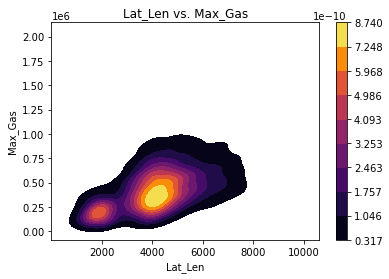

In [116]:
ax = sns.kdeplot(df_z['Lat_Len'].values,df_z['Max_Gas'].values, shade=True, n_levels = 10, cbar= True, cmap = plt.cm.inferno, thresh=0.05)
ax.set_xlabel('Lat_Len'); ax.set_ylabel('Max_Gas'); ax.set_title('Lat_Len vs. Max_Gas')

#### Select Columns

In [119]:
x = df_z.drop(['log_Max_Gas', 'Max_Gas', 'z_logMaxgas', 'z_prop', 'z_Lat_Len', 'z_Fluid'],axis=1) ## Max_Gas is the target values
y = df_z['log_Max_Gas']
x.head()

,Lat_Len,Vert_Len,Fluid,Proppant
Index,,,,
1,1507,6950,15904,492500
2,1707,8265,48520,458360
3,1644,6039,89263,1915300
4,1646,6067,88929,1849000
5,1645,6048,91243,2829500


#### Standardize
Standardize features by removing the mean and scaling to unit variance

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)   
scaled_features = scaler.transform(x)
x_z_std = pd.DataFrame(scaled_features,columns=x.columns)
x_z_std.head()

,Lat_Len,Vert_Len,Fluid,Proppant
0,-1.930985,1.668194,-1.254454,-1.966617
1,-1.785772,2.599476,-0.809319,-1.988957
2,-1.831514,1.023025,-0.253269,-1.035579
3,-1.830062,1.042855,-0.257827,-1.078964
4,-1.830788,1.029399,-0.226246,-0.437354


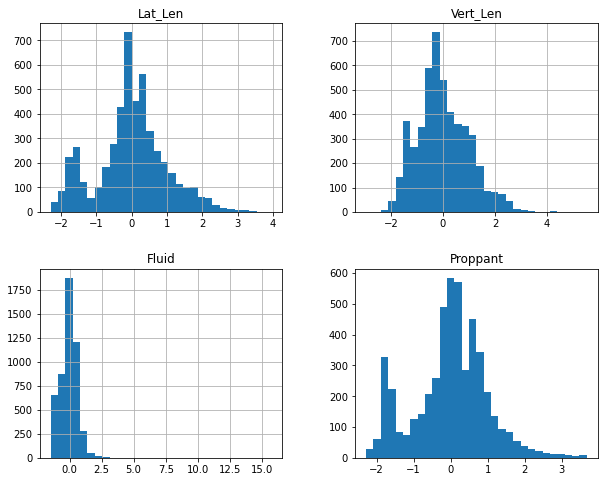

In [123]:
x_z_std.hist(bins=30, figsize=(10, 8))
plt.grid(which='both')
plt.show()

#### Split training and testing data

In [124]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_z_std, y, test_size=0.20, random_state=42)
print(x_train.info())
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3997 entries, 3941 to 860
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Lat_Len   3997 non-null   float64
 1   Vert_Len  3997 non-null   float64
 2   Fluid     3997 non-null   float64
 3   Proppant  3997 non-null   float64
dtypes: float64(4)
memory usage: 156.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 84 to 4001
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Lat_Len   1000 non-null   float64
 1   Vert_Len  1000 non-null   float64
 2   Fluid     1000 non-null   float64
 3   Proppant  1000 non-null   float64
dtypes: float64(4)
memory usage: 39.1 KB
None


#### Training and Testing
##### Linear Regression

Coefficients: 
 [ 0.21801466 -0.00683644  0.04633576  0.07390148]
Intercept:  12.834731966927597
RMSE: 0.46
R2: 0.31
Correlation: 0.56


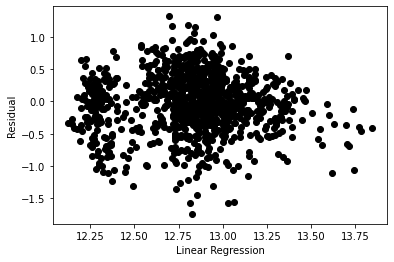

In [125]:
reg = linear_model.LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The intercept
print('Intercept: ', reg.intercept_)
# The mean squared error
print('RMSE: %.2f'
      % mean_squared_error(y_test, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print('R2: %.2f'
      % r2_score(y_test, y_pred))
# The Correlation between predict and test
print('Correlation: %.2f' 
      % np.corrcoef(y_test, y_pred)[0,1])

# Plot outputs
plt.scatter(y_pred, (y_test-y_pred),  color='black')
#plt.plot(x_test['Lat_Len'], y_pred, color='blue', linewidth=3)

plt.xlabel('Linear Regression')
plt.ylabel('Residual')
plt.show()

count    5.168000e+03
mean     1.555068e+05
std      3.707851e+05
min      6.600000e+01
25%      7.807425e+04
50%      1.075520e+05
75%      1.380805e+05
max      1.300911e+07
Name: Fluid, dtype: float64
90009.375


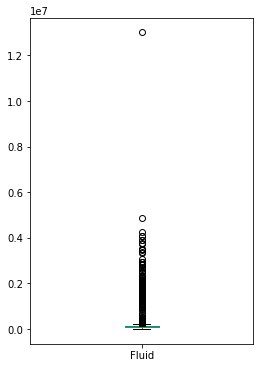

In [117]:
#### Comparison between z-score and IQR
df['Fluid'].plot(kind='box', figsize=(4, 6))
print(df['Fluid'].describe())
print(1.5*IQR_fl)

Relative small IQR and relative large standart deviation in df['Fluid'] causes IQR method to remove more outlier than z-score method

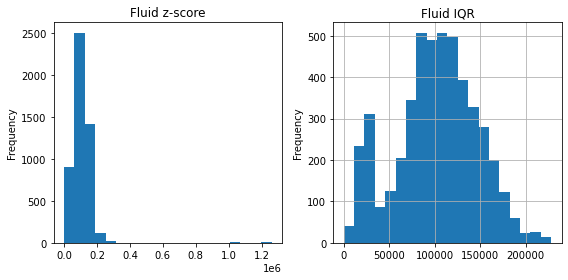

In [118]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) 
ax1 = fig.add_subplot(1, 2, 2) 
df_z['Fluid'].plot(kind='hist', bins=20, figsize=(8, 4), ax=ax0)
ax0.set_title ('Fluid z-score')

df_IQR['Fluid'].plot(kind='hist', bins=20, figsize=(8, 4), ax=ax1)
ax1.set_title ('Fluid IQR')

fig.tight_layout()
plt.grid(which='both')
plt.show()